In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from symbolic_control import (
    UnicycleDynamics, Abstraction,
    RegionLabeler, regex_to_nfa,
    ProductSynthesis, ProductState
)

## Configuration Parameters

In [14]:
# ============================================================
# GRID PARAMETERS
# ============================================================
# State bounds: [0, 10] x [0, 10] x [-pi, pi]
x_min, x_max = 0, 10      # Position x bounds
y_min, y_max = 0, 10      # Position y bounds
theta_min, theta_max = -np.pi, np.pi  # Heading angle bounds

# Cell size - SMALLER eta means transitions don't span region boundaries
# This is critical for robust synthesis to work!
eta = 0.25                    # Reduced from 0.4 to allow robust region entry

# ============================================================
# DYNAMICS PARAMETERS  
# ============================================================
tau = 0.4                     # Reduced sampling period for tighter over-approximation
w_bound = 0.05               # Reduced disturbance for tighter bounds

# Control discretization
v_values = np.linspace(0.25, 1.0, num=5)  # Linear velocity u1 ∈ [-1, 1]
omega_values = np.linspace(-1.0, 1.0, num=5)  # Angular velocity u2 ∈ [-1, 1]

print(f"Expected position growth bound: ~tau * v_max = {tau * 1.0:.2f}")
print(f"Region A width: 1.5")
print(f"For robust entry, growth should be < region_width/2 = 0.75")

Expected position growth bound: ~tau * v_max = 0.40
Region A width: 1.5
For robust entry, growth should be < region_width/2 = 0.75


In [15]:
# ============================================================
# REGIONS (named regions on the grid - defined in x,y only)
# Format: 'name': [x_min, x_max, y_min, y_max]
# ============================================================
# LARGER regions make robust entry easier!
regions = {
    'A': [0.5, 3.0, 0.5, 3.0],      # Bottom-left (LARGER start region)
    'B': [7.0, 9.5, 7.0, 9.5],      # Top-right (LARGER goal region)
    'O': [1.0, 9.0, 4.0, 6.0],      # Center obstacle
}

# ============================================================
# SPECIFICATION (Regular Expression)
# ============================================================
spec = "A[^O]*B"

# ============================================================
# START POSITION (x, y, theta)
# ============================================================
# Start outside A to test if we can robustly reach A first
start_position = np.array([5.0, 2.0, np.pi/4])  # Start in middle-bottom

## Setup Dynamics and Abstraction

In [16]:
# Create unicycle dynamics
dynamics = UnicycleDynamics(
    tau=tau, 
    w_bound=w_bound, 
    v_values=v_values, 
    omega_values=omega_values
)
print(f"State dimension: {dynamics.state_dim}")
print(f"Control set: {len(dynamics.control_set)} controls")
print(f"Control samples: {dynamics.control_set[:3]}...")

State dimension: 3
Control set: 25 controls
Control samples: [array([ 0.25, -1.  ]), array([ 0.25, -0.5 ]), array([0.25, 0.  ])]...


In [17]:
# Create abstraction with 3D state bounds
state_bounds = np.array([
    [x_min, x_max],         # x1 bounds
    [y_min, y_max],         # x2 bounds  
    [theta_min, theta_max]  # x3 (theta) bounds
])

abstraction = Abstraction(
    dynamics=dynamics,
    state_bounds=state_bounds,
    eta=eta
)

print(f"Grid shape: {abstraction.grid_shape}")
print(f"Total cells: {abstraction.num_cells}")
print(f"State bounds:\n{abstraction.state_bounds}")

Grid shape: (40, 40, 26)
Total cells: 41600
State bounds:
[[ 0.         10.        ]
 [ 0.         10.        ]
 [-3.14159265  3.14159265]]


In [ ]:
# Build transitions (this may take a while for 3D)
print("Building transitions...")
abstraction.build_transitions()
print(f"Total transitions: {len(abstraction.transitions)}")

Building transitions...
Building transitions for 41600 cells × 25 controls...


 71%|███████   | 29398/41600 [01:33<01:09, 176.76it/s]

## Run Product Synthesis

In [ ]:
# Create product synthesis and run
synth = ProductSynthesis(
    abstraction=abstraction,
    regions=regions,
    spec=spec
)

winning_set = synth.run(verbose=True)

Specification: A[^O]*B
NFA states: 8, alphabet: {'A', 'B', [^O]}

SAFETY SYNTHESIS (Automaton Pruning)
Qₛ: 33696 cells | R₀: 33696 cells
Iteration 1: 33290 cells (removed 406)
Iteration 2: 33230 cells (removed 60)
Iteration 3: 33160 cells (removed 70)
Iteration 4: 33086 cells (removed 74)
Iteration 5: 33038 cells (removed 48)
Iteration 6: 33004 cells (removed 34)
Iteration 7: 32978 cells (removed 26)
Iteration 8: 32964 cells (removed 14)
Iteration 9: 32950 cells (removed 14)
Iteration 10: 32944 cells (removed 6)
Iteration 11: 32938 cells (removed 6)
Iteration 12: 32932 cells (removed 6)
Iteration 13: 32930 cells (removed 2)
Iteration 14: 32928 cells (removed 2)
Iteration 15: 32926 cells (removed 2)
Iteration 16: 32926 cells (removed 0)
Converged! S* = 32926 cells (97.7%)
Safe transitions: 742018
PRODUCT AUTOMATON CONSTRUCTION
Initial product states: 32926
Accepting in initial: 0
  Explored 10000 states, queue size: 24023
  Explored 20000 states, queue size: 15993
  Explored 30000 state

## Visualize Results

For 3D state space, we project onto (x1, x2) plane by showing cells that are winning for **any** heading angle.

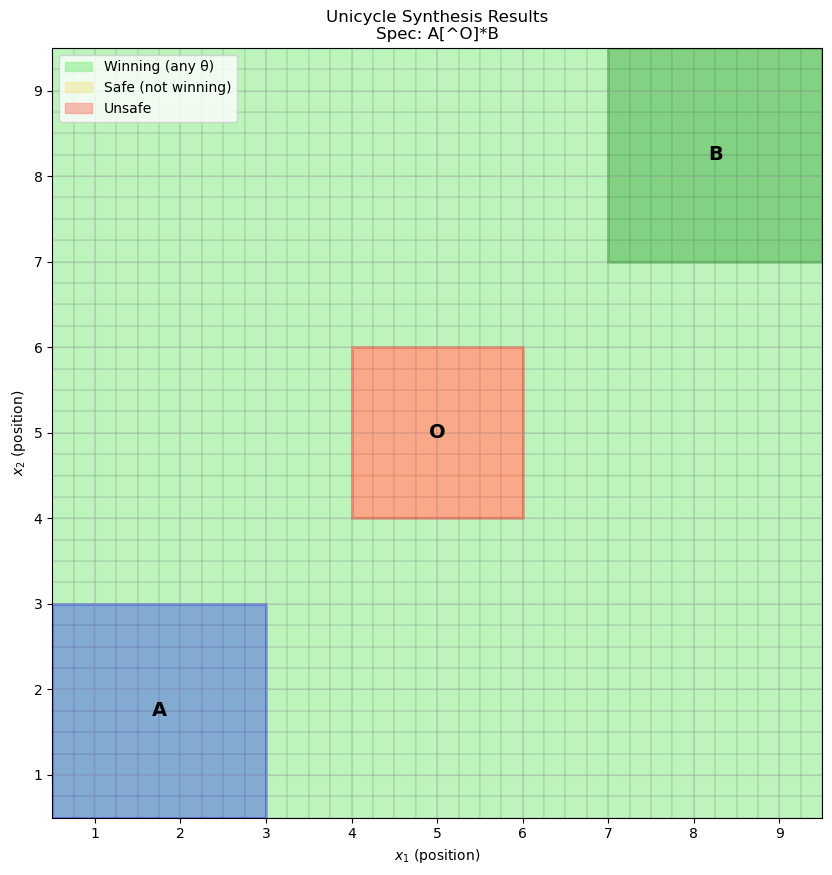

In [ ]:
def visualize_unicycle_synthesis(synth, ax=None, title="Unicycle Synthesis Results"):
    """
    Visualize synthesis results projected onto (x1, x2) plane.
    A cell is shown as winning if it's winning for ANY heading angle.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    abst = synth.abstraction
    nx, ny, ntheta = abst.grid_shape
    
    # Get winning cells and project to (x, y)
    winning_cells = synth.get_winning_cells()
    safe_cells = synth.safe_automaton.safe_states if synth.safe_automaton else set()
    
    # Project 3D cells to 2D (x, y)
    winning_xy = set()
    safe_xy = set()
    
    for cell_idx in winning_cells:
        i, j, k = np.unravel_index(cell_idx, abst.grid_shape)
        winning_xy.add((i, j))
    
    for cell_idx in safe_cells:
        i, j, k = np.unravel_index(cell_idx, abst.grid_shape)
        safe_xy.add((i, j))
    
    # Draw cells
    for i in range(nx):
        for j in range(ny):
            x = abst.state_bounds[0, 0] + i * abst.eta
            y = abst.state_bounds[1, 0] + j * abst.eta
            
            if (i, j) in winning_xy:
                color = 'lightgreen'
                alpha = 0.6
            elif (i, j) in safe_xy:
                color = 'khaki'
                alpha = 0.5
            else:
                color = 'salmon'
                alpha = 0.5
            
            rect = mpatches.Rectangle(
                (x, y), abst.eta, abst.eta,
                linewidth=0.3, edgecolor='gray',
                facecolor=color, alpha=alpha
            )
            ax.add_patch(rect)
    
    # Draw all named regions
    colors_map = {'A': 'blue', 'B': 'green', 'O': 'red'}
    for name, bounds in synth.regions.items():
        color = colors_map.get(name, 'purple')
        rect = mpatches.Rectangle(
            (bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
            linewidth=2, edgecolor=color, facecolor=color, alpha=0.3
        )
        ax.add_patch(rect)
        ax.text(
            (bounds[0] + bounds[1]) / 2,
            (bounds[2] + bounds[3]) / 2,
            name, fontsize=14, fontweight='bold',
            ha='center', va='center', color='black'
        )
    
    # Legend
    legend_patches = [
        mpatches.Patch(color='lightgreen', alpha=0.6, label='Winning (any θ)'),
        mpatches.Patch(color='khaki', alpha=0.5, label='Safe (not winning)'),
        mpatches.Patch(color='salmon', alpha=0.5, label='Unsafe'),
    ]
    ax.legend(handles=legend_patches, loc='upper left')
    
    ax.set_xlim(abst.state_bounds[0, 0], abst.state_bounds[0, 1])
    ax.set_ylim(abst.state_bounds[1, 0], abst.state_bounds[1, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('$x_1$ (position)')
    ax.set_ylabel('$x_2$ (position)')
    ax.set_title(f"{title}\nSpec: {synth.spec}")
    ax.grid(True, alpha=0.3)
    
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
visualize_unicycle_synthesis(synth, ax=ax)
plt.show()

## Simulate Controller

In [ ]:
# Check if start position is in winning set
start_cell = synth.abstraction.point_to_cell(start_position)
initial_nfa = frozenset(synth.nfa.get_initial_states())

print(f"Start position: {start_position}")
print(f"Start cell: {start_cell}")
print(f"Initial NFA states: {initial_nfa}")
print(f"In winning set: {synth.is_winning(initial_nfa, start_cell)}")

Start position: [5.         2.         0.78539816]
Start cell: 17019
Initial NFA states: frozenset({0})
In winning set: True


In [ ]:
# Run simulation
trajectory, nfa_trace = synth.simulate(start_position, max_steps=100, verbose=True)
print(f"\nTrajectory length: {len(trajectory)} steps")
print(f"Final NFA states: {nfa_trace[-1] if nfa_trace else 'N/A'}")
print(f"Reached accepting: {synth.is_accepting(nfa_trace[-1]) if nfa_trace else False}")

Step 28: Reached accepting state at [7.81150662 7.11461497 1.99647445]

Trajectory length: 29 steps
Final NFA states: frozenset({2, 3, 5, 6, 7})
Reached accepting: True


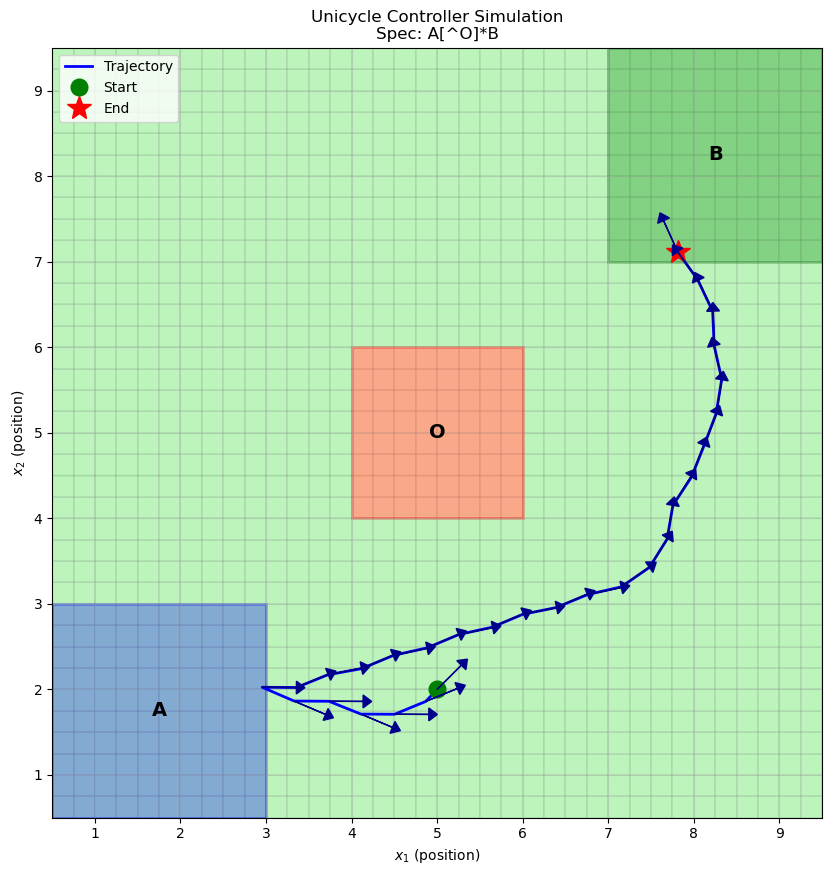

In [ ]:
def plot_unicycle_trajectory(synth, trajectory, ax=None):
    """
    Plot unicycle trajectory with heading arrows.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # First draw the synthesis results
    visualize_unicycle_synthesis(synth, ax=ax, title="Unicycle Controller Simulation")
    
    # Plot trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory', zorder=10)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, label='Start', zorder=11)
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=18, label='End', zorder=11)
    
    # Add heading arrows at regular intervals
    n_arrows = min(15, len(trajectory))
    step = max(1, len(trajectory) // n_arrows)
    arrow_length = 0.4
    
    for i in range(0, len(trajectory), step):
        x, y, theta = trajectory[i]
        dx = arrow_length * np.cos(theta)
        dy = arrow_length * np.sin(theta)
        ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.1, 
                 fc='darkblue', ec='darkblue', zorder=12)
    
    ax.legend(loc='upper left')
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
plot_unicycle_trajectory(synth, trajectory, ax=ax)
plt.show()

## Summary Statistics

In [ ]:
winning_cells = synth.get_winning_cells()

print("=" * 50)
print("UNICYCLE PRODUCT SYNTHESIS SUMMARY")
print("=" * 50)
print(f"Specification: {spec}")
print(f"Grid shape: {abstraction.grid_shape}")
print(f"Total cells: {abstraction.num_cells}")
print(f"Cell size (eta): {eta}")
print(f"")
print(f"NFA states: {len(synth.nfa.states)}")
print(f"NFA alphabet: {synth.nfa.alphabet}")
print(f"")
print(f"Product states: {len(synth.product.states)}")
print(f"Product accepting: {len(synth.product.accepting_states)}")
print(f"")
print(f"Safe cells: {len(synth.safe_automaton.safe_states)} ({100*len(synth.safe_automaton.safe_states)/abstraction.num_cells:.1f}%)")
print(f"Winning product states: {len(synth.winning_set)}")
print(f"Winning cells: {len(winning_cells)} ({100*len(winning_cells)/abstraction.num_cells:.1f}%)")
print(f"Reachability iterations: {len(synth.reach_sets) - 1}")

UNICYCLE PRODUCT SYNTHESIS SUMMARY
Specification: A[^O]*B
Grid shape: (36, 36, 26)
Total cells: 33696
Cell size (eta): 0.25

NFA states: 8
NFA alphabet: {'A', 'B', [^O]}

Product states: 145722
Product accepting: 28802

Safe cells: 32926 (97.7%)
Winning product states: 112362
Winning cells: 31244 (92.7%)
Reachability iterations: 101
